# Multiple Object Partial Style Transfer (Image)

In [132]:
import os, json, sys
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My\ Drive/NYU/Deep\ Learning/project

/content/gdrive/My Drive/NYU/Deep Learning/project


## Package Install
This is the same as the `join_model.ipynb`, need not to install if this is pre-installed

In [ ]:
# ! git clone https://github.com/dbolya/yolact.git

# ! git clone https://github.com/pytorch/examples.git 
# ! cp -r examples/fast_neural_style fast_neural_style
# ! rm -r examples
# ! python fast_neural_style/download_saved_models.py
# ! rm -r saved_models.zip
# ! mv -v saved_models/*.pth model

## Package Import

In [3]:
import os, json, tqdm, argparse, sys, argparse, time, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from PIL import Image

from torchvision import transforms

In [4]:
%cd yolact
from eval import *
from data import cfg, set_cfg, set_dataset
import os, time

from yolact import Yolact
import torch.backends.cudnn as cudnn
%cd ../

/content/gdrive/My Drive/NYU/Deep Learning/project/yolact
/content/gdrive/My Drive/NYU/Deep Learning/project


In [5]:
%cd fast_neural_style/neural_style
from transformer_net import TransformerNet
from vgg import Vgg16
%cd ../../

/content/gdrive/My Drive/NYU/Deep Learning/project/fast_neural_style/neural_style
/content/gdrive/My Drive/NYU/Deep Learning/project


## Model Setting

In [6]:
parser = {
    "cuda":True,
    "content_image":"data/anna-kendrick.jpg",
    "content_scale":None,
    
    "yolact_model":"model/yolact_base_54_800000.pth",
    "style_model_candy":"model/candy.pth",
    "style_model_rain_princess":"model/rain_princess.pth",
    "style_model_udnie":"model/udnie.pth",
    "style_model_mosaic":"model/mosaic.pth",
}

args = argparse.Namespace(**parser)

## Import image

In [7]:
def load_image(filename, size=None, scale=None):
    img = Image.open(filename).convert('RGB')
    if size is not None:
        img = img.resize((size, size), Image.ANTIALIAS)
    elif scale is not None:
        img = img.resize((int(img.size[0] / scale), int(img.size[1] / scale)), Image.ANTIALIAS)
    return img

def img_pre(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = load_image(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.Resize((800, 1200)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)
    return content_image

## Load Model

In [12]:
def load_segment_model(args):
    yolact_model = Yolact()
    yolact_model.load_weights(args.yolact_model)
    yolact_model = yolact_model.cuda()
    return yolact_model

def load_style_model(args, model_path):
    device = torch.device("cuda" if args.cuda else "cpu")
    style_model = TransformerNet()
    state_dict = torch.load(model_path)
    for k in list(state_dict.keys()):
        if re.search(r'in\d+\.running_(mean|var)$', k):
            del state_dict[k]
    style_model.load_state_dict(state_dict)
    style_model.to(device)
    return style_model

## Run one trail for multiple object

In [13]:
# import model

# # yolact
seg_model = load_segment_model(args)

# # style transfer
candy = load_style_model(args, args.style_model_candy)
rain_princess = load_style_model(args, args.style_model_rain_princess)
udnie = load_style_model(args, args.style_model_udnie)
mosaic = load_style_model(args, args.style_model_mosaic)

/usr/local/lib/python3.7/dist-packages/torch/jit/_recursive.py:202: UserWarning: 'lat_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/usr/local/lib/python3.7/dist-packages/torch/jit/_recursive.py:202: UserWarning: 'pred_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))
/usr/local/lib/python3.7/dist-packages/torch/jit/_recursive.py:202: UserWarning: 'downsample_layers' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  " but it is a non-constant {}. Consider removing it.".format(name, hint))


In [126]:
content_img = img_pre(args)

seg_model.eval()
with torch.no_grad():
    cudnn.fastest = True
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    frame = content_img.squeeze(0).permute(1, 2, 0)
    batch = FastBaseTransform()(frame.unsqueeze(0))
    res = seg_model(batch)

with timer.env('Postprocess'):
    save = cfg.rescore_bbox
    cfg.rescore_bbox = True
    cfg.mask_proto_debug = False
    t = postprocess(res, frame.shape[1], frame.shape[0], visualize_lincomb = False, crop_masks = False, score_threshold = 0.15)

    classes = t[0].cpu().numpy()
    classes_name = ["background"]+[cfg.dataset.class_names[i] for i in classes]
    score = t[1]
    mask = t[3]
    
    mask_sum_idx = mask.sum(dim=0).view(mask.size(1), mask.size(2), -1)

In [65]:
style_image_list = []
for style in [candy, rain_princess, udnie, mosaic]:
    style.eval()
    with torch.no_grad():
        style_output = style(content_img)
        style_transferred_img = style_output.squeeze(0).permute(1, 2, 0)
        style_image_list.append(style_transferred_img)

In [ ]:
img_name_dict = {
    "original":frame, 
    "candy":style_image_list[0],
    "rain_princess":style_image_list[1],
    "udnie":style_image_list[2],
    "mosaic":style_image_list[3],
}

### Setting the object style (including background)

In [130]:
print("The output class: {}".format(classes_name))

The output class: ['background', 'person', 'tie']


In [128]:
# Set the object style
# =============== set object style with the given order ===============
obj_style = ["mosaic", "rain_princess", "udnie"]
# =====================================================================

assert len(obj_style)==len(classes_name)
image_syth = [img_name_dict[i] for i in obj_style]

### Result

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1199.5, 799.5, -0.5)

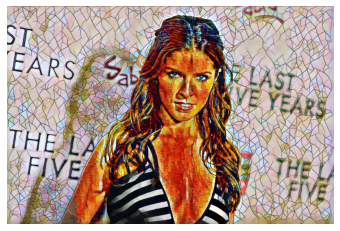

In [134]:
img_res = torch.zeros_like(image_syth[0])
for i in range(len(image_syth)):
    img_res+=image_syth[i]*(mask_sum_idx==i)

plt.imshow((img_res).cpu().numpy()/255)
plt.axis('off')